# **Programming for Applied Deep Learning (GKSG008-01)**
> ### **20181202 김수미**
> ### LeNet_with_Conv2d(1) (Based on 11/18 Lecture)

1. Textbook 6.6.4 Exercise (GPU must be used)
- Replace the average pooling with maximum pooling. What happens?
- Try to construct a more complex network based on LeNet to improve its accuracy.
- Adjust the convolution window size.
- Adjust the number of output channels.
- Adjust the activation function (e.g., ReLU).
- Adjust the number of convolution layers.
- Adjust the number of fully connected layers.
- Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
- Try out the improved network on the original MNIST dataset.
- Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).

**◦ Load GPU Provided by Google Colab**

In [1]:
!nvidia-smi

Fri Nov 19 07:55:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**◦ Import Libraries and Define Functions**

In [ ]:
pip install d2l

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

import numpy as np
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from d2l.torch import *
from torch.utils.data import DataLoader

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
    
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

In [6]:
def load_data_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
      trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(root="../data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.MNIST(root="../data",train=False,transform=trans,download=True)
    return(data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),
           data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=4))

**◦ Load Dataset (Fashion Mnist)**

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

**◦ Original Net and Training Result**

In [8]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120),
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(),
                    nn.Linear(84, 10))

loss 0.462, train acc 0.827, test acc 0.810
21287.5 examples/sec on cuda:0


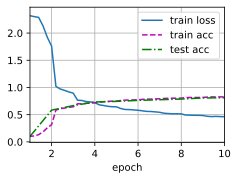

In [9]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ Replace the average pooling with maximum pooling.**

In [10]:
net2 = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2),
                     nn.Sigmoid(),
                     nn.MaxPool2d(kernel_size=2, stride=2),
                     nn.Conv2d(6, 16, kernel_size=5),
                     nn.Sigmoid(),
                     nn.MaxPool2d(kernel_size=2, stride=2),
                     nn.Flatten(),
                     nn.Linear(16 * 5 * 5, 120),
                     nn.Sigmoid(),
                     nn.Linear(120, 84),
                     nn.Sigmoid(),
                     nn.Linear(84, 10))

loss 0.413, train acc 0.847, test acc 0.815
23027.1 examples/sec on cuda:0


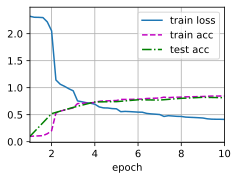

In [11]:
lr, num_epochs = 0.9, 10
train_ch6(net2, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**< Average Pooling Result >**
> loss : 0.462 / train acc : 0.827 / test acc : 0.810

**< Maximum Pooling Result >**
> loss : 0.413 / train acc : 0.847 / test acc : 0.815

**Accuracy :** Maximum Pooling > Average Pooling

**◦ Construct a more complex network based on LeNet to improve its accuracy.**

- Convolution kernel size : 5 (original)
- The number of output channels : 32, 64
- Activation function : Sigmoid, ReLU
- The number of convolution layers : 2 (original)
- The number of fully connected layers : 3 (original)
- Learning rates : 0.6
- Batch size : 128
- Number of epochs : 100

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [31]:
net3 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, padding=2),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=2),

                     nn.Conv2d(32, 64, kernel_size=5),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=2),

                     nn.Flatten(),
                     
                     nn.Linear(1600, 400),
                     nn.ReLU(),

                     nn.Linear(400, 100),
                     nn.Sigmoid(),
                     
                     nn.Linear(100, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net3:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 32, 28, 28])
ReLU output shape:	 torch.Size([1, 32, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 32, 14, 14])
Conv2d output shape:	 torch.Size([1, 64, 10, 10])
ReLU output shape:	 torch.Size([1, 64, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 64, 5, 5])
Flatten output shape:	 torch.Size([1, 1600])
Linear output shape:	 torch.Size([1, 400])
ReLU output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 100])
Sigmoid output shape:	 torch.Size([1, 100])
Linear output shape:	 torch.Size([1, 10])


loss 0.000, train acc 1.000, test acc 0.918
10097.3 examples/sec on cuda:0


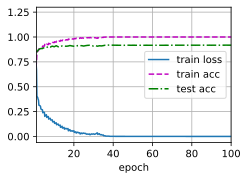

In [14]:
# Takes about 20 min
lr, num_epochs = 0.6, 100
train_ch6(net3, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**< Average Pooling Result >**
> loss : 0.462 / train acc : 0.827 / test acc : 0.810

**< Maximum Pooling Result >**
> loss : 0.413 / train acc : 0.847 / test acc : 0.815

**< Customized Network Result >**
> loss : 0.000 / train acc : 1.000 / test acc : 0.918

**Accuracy :** Customized > Maximum Pooling > Average Pooling

**◦ Try out the improved network on the original MNIST dataset.**

In [ ]:
# Load MNIST dataset
batch_size = 128
train_iter, test_iter = load_data_mnist(batch_size)

loss 0.000, train acc 1.000, test acc 0.994
10165.8 examples/sec on cuda:0


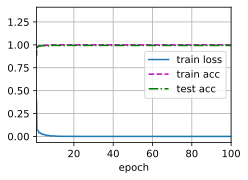

In [16]:
# Takes about 20 min
lr, num_epochs = 0.6, 100
train_ch6(net3, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**◦ Display the activations of the first and second layer of LeNet for different inputs (Fashion MNIST).**

In [ ]:
# Load fashion MNIST dataset
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

sample_data = []; flag = 0
for data in train_iter:
  x,y = data
  sample_data.append(x)
  flag += 1
  if flag == 2: break

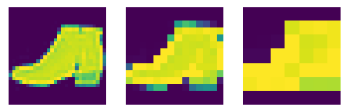

In [51]:
depth = 1; images=[];

X = sample_data[0]
image = X[0,0]
image = image.numpy()
images.append(image)

for layer in net3:
  if depth == 3 or depth == 6 :
    X = layer(X)
    image = X[0,0]
    image = image.numpy()
    images.append(image)
  depth += 1

fig = plt.figure()
rows,cols = 1,3
for i in range(3):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i])
  ax1.axis("off")
plt.show()

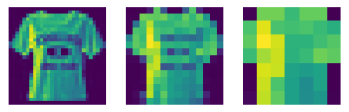

In [49]:
depth = 1; images=[];

X = sample_data[1]
image = X[0,0]
image = image.numpy()
images.append(image)

for layer in net3:
  if depth == 3 or depth == 6 :
    X = layer(X)
    image = X[0,0]
    image = image.numpy()
    images.append(image)
  depth += 1

fig = plt.figure()
rows,cols = 1,3
for i in range(3):
  ax1 = fig.add_subplot(rows, cols, i+1)
  ax1.imshow(images[i])
  ax1.axis("off")
plt.show()